In [1]:
import numpy as np 
import glob
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

def plot_image(img, title=None, size=(8,5)):
    plt.figure(figsize=size)
    plt.axis("off")
    
    if title is not None:
        plt.title(title)
        
    if len(img.shape) == 3:
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
    else:
        plt.imshow(img, cmap='gray')        

    plt.show()

In [2]:
def read_images(image_dir_list, include_flipped=False):    
    images = []
    
    for img_dir in image_dir_list:         
    
        # get all image files in the current directory
        img_file_list = glob.glob('./training_data/' + img_dir + '/?*.png')
        
        img_counter = 0
        
        for img_file in img_file_list:
            img_counter += 1  
            
            if img_counter % 1 == 0:
                
                img = cv2.imread(img_file)        
                images.append(img)

                if include_flipped:
                    images.append(cv2.flip(img,1))
    
    print('imported {} images'.format(len(images)))  
            
    return images         

In [3]:
def normalize(features, init=False):
    # scales a vector to have zero mean and unit variance    
    global scaler 
    
    if init:         
        # initialize the scaler for normalization
        scaler = StandardScaler().fit(features)
        
    # apply the scaler 
    scaled_vec = scaler.transform(features)
    
    return scaled_vec
        

In [4]:
def get_hog_features(img, make_vector=False):    
    global pix_per_cell
    
    pix_per_cell = 8
    num_orientations = 9  
    cell_per_block = 2

    features = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                      visualise=False, feature_vector=make_vector)

    return features

def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    
def extract_features(images):
    features = []
    
    for img in images:  
        
         # convert image color space    
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) 
        
        # extract histogram features on all color channels
        n_bins = 20    
        hist_feature_vec_0, bins = np.histogram(img[:,:,0], n_bins, (0, 256))
        hist_feature_vec_1, bins = np.histogram(img[:,:,1], n_bins, (0, 256))
        hist_feature_vec_2, bins = np.histogram(img[:,:,2], n_bins, (0, 256))
        
        # extract HOG features on all color channels
        hog_feature_vec_0 = get_hog_features(img[:,:,0], make_vector=True) 
        hog_feature_vec_1 = get_hog_features(img[:,:,1], make_vector=True)
        hog_feature_vec_2 = get_hog_features(img[:,:,2], make_vector=True)
        
        # extract spatial binning features
        img_resized = cv2.resize(img, (16, 16))
        spatial_feature_vec = img_resized.ravel()
        
        feature_vec_combined = np.concatenate((hist_feature_vec_0, hist_feature_vec_1, hist_feature_vec_2, 
                                               hog_feature_vec_0,  hog_feature_vec_1,  hog_feature_vec_2, 
                                               spatial_feature_vec))       

        features.append(feature_vec_combined)
        
    return features


In [5]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
import pickle

def calculate_test_accuracy(classifier, features, labels):   
    
    pred = classifier.predict(features)
    num_correct = np.count_nonzero(pred == labels)
    acc = 1.0*num_correct/len(labels)
            
    return acc            

def create_classifier(vehicle_features, non_vehicle_features):

    # create input data from features
    X_raw = np.vstack((vehicle_features, non_vehicle_features))
    X_raw = X_raw.reshape((X_raw.shape[0], X_raw.shape[1]))
    
    # normalize the features
    print('normalizing features ...')
    X = normalize(X_raw, init=True)

    # create output labels: 1=vehicle, 0=non-vehicle
    vehicle_labels = np.ones((len(vehicle_features)))
    non_vehicle_labels = np.zeros((len(non_vehicle_features)))
    y = np.hstack((vehicle_labels, non_vehicle_labels))

    # shuffle the data
    X, y = shuffle(X, y)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    classifier = RandomForestClassifier(n_estimators=5, random_state=42)
        
    print('begin training ...')
    
    classifier.fit(X_train, y_train)  
    
    print('finished training!')    
    
    acc = calculate_test_accuracy(classifier, X_test, y_test)
    
    print('test accuracy = {:.3f}'.format(acc))
    
    # save the classifier and scaler
    global scaler 
    with open('classifier.pkl', 'wb') as fid:
        pickle.dump(classifier, fid)  
        pickle.dump(scaler, fid)  
        print('saved classifier')
    
    return classifier


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
train_classifier = False

if train_classifier: # train a new classifier 

    # read vehicle images
    vehicle_images = read_images(['vehicles/GTI_Far', 'vehicles/GTI_Left', 'vehicles/GTI_MiddleClose', 
                    'vehicles/GTI_Right', 'vehicles/KITTI_extracted']) #, 'vehicles/udacity'])
    
    # read non-vehicle images
    #non_vehicle_images = read_images(['non-vehicles/GTI', 'non-vehicles/Extras'])
    non_vehicle_images = read_images(['non-vehicles/Extras'], include_flipped=True)
    
    # extract features from images
    vehicle_features = extract_features(vehicle_images)  
    non_vehicle_features = extract_features(non_vehicle_images)  
    
    # train the classifier
    classifier = create_classifier(vehicle_features, non_vehicle_features) 

else: # open a saved classifier and scaler
    global scaler     
    with open('classifier.pkl', 'rb') as fid:
        classifier = pickle.load(fid)   
        scaler = pickle.load(fid) 
        print('loaded classifier')


loaded classifier


In [7]:
def draw_patches(img_input, patches):
    
    img = np.copy(img_input)
    
    for patch in patches:
        img = cv2.rectangle(img, (patch[0], patch[1]), (patch[2], patch[3]), (0,255,0), 1)
        
    return img


class DetectionLevel:
    def __init__(self, x_range, y_range, scaling_factor, stride):
        self.x_range = x_range # cropping percentages relative to the original image 
        self.y_range = y_range
        self.scaling_factor = scaling_factor  
        self.stride = stride
        
        # corner points of the scaled image in the original image
        self.p1 = None
        self.p2 = None    
        
    def crop_image(self, img):   
        # crop img to the dimensions specified by x_range and y_range
        
        size_x = img.shape[1]
        size_y = img.shape[0]
        
        self.p1 = (int(self.x_range[0]*size_x), int(self.y_range[0]*size_y))
        self.p2 = (int(self.x_range[1]*size_x), int(self.y_range[1]*size_y))
        
        return cv2.resize(img[self.p1[1]:self.p2[1], self.p1[0]:self.p2[0]],                           
                          None, fx=self.scaling_factor, fy=self.scaling_factor, interpolation=cv2.INTER_AREA)
    
    
    def get_patches(self, img):
        # calculate a list of patches (=sub region coordinates) on which the classifier will later run
        
        global pix_per_cell

        cells_per_patch = int(64/pix_per_cell)

        img_patches = []
        hog_patches = []   

        px = 0
        py = 0     
        qx = px + pix_per_cell*cells_per_patch 
        qy = py + pix_per_cell*cells_per_patch 

        while qx < img.shape[1]:         
            while qy < img.shape[0]:

                img_patches.append((px, py, qx, qy)) 
                hog_patches.append((int(1.0*px/pix_per_cell), 
                                    int(1.0*py/pix_per_cell), 
                                    int(1.0*qx/pix_per_cell), 
                                    int(1.0*qy/pix_per_cell)))           

                py += self.stride*pix_per_cell          
                qy = py + pix_per_cell*cells_per_patch 

            px += self.stride*pix_per_cell
            qx = px + pix_per_cell*cells_per_patch   

            py = 0   
            qy = py + pix_per_cell*cells_per_patch    

        return img_patches, hog_patches   
    
    
# define regions and scaling levels for where to detect vehicles in the image 
detection_levels = []
detection_levels.append(DetectionLevel((0.4, 0.8), (0.54, 0.7), 1.1, 1)) 
detection_levels.append(DetectionLevel((0.4, 0.9), (0.54, 0.7), 1.0, 1)) 
detection_levels.append(DetectionLevel((0.4, 1), (0.5, 0.8), 0.6, 1))
detection_levels.append(DetectionLevel((0.4, 1), (0.5, 0.8), 0.4, 1))

          

In [8]:
def calculate_heat_map(img_orig):
    
    n_bins = 20 
    
    #if heat_map is None:
    heat_map = np.zeros((img_orig.shape[0], img_orig.shape[1]))    

    for level in detection_levels:
        
        # resize the image according to the current detection level 
        img = level.crop_image(img_orig) 
        
        # convert image color space
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  
        
        # calculate HOG feature map for the image on the Y channel
        hog_map_0 = get_hog_features(img[:,:,0], make_vector=False)     
        hog_map_1 = get_hog_features(img[:,:,1], make_vector=False)  
        hog_map_2 = get_hog_features(img[:,:,2], make_vector=False) 

        # get a list of patches (sub-regions of the image) for sub-sampling
        img_patches, hog_patches = level.get_patches(img)   
            
        for img_patch, hog_patch in zip(img_patches, hog_patches):
            
            # create a 64x64 image by cropping it out of the bigger image
            current_image = img[img_patch[1]:img_patch[3], img_patch[0]:img_patch[2]]    
            
            # extract histogram features on all color channels 
            hist_feature_vec_0, bins = np.histogram(current_image[:,:,0], n_bins, (0, 256))
            hist_feature_vec_1, bins = np.histogram(current_image[:,:,1], n_bins, (0, 256))
            hist_feature_vec_2, bins = np.histogram(current_image[:,:,2], n_bins, (0, 256)) 
        
            # extract spatial binning features
            img_resized = cv2.resize(current_image, (16, 16))
            spatial_feature_vec = img_resized.ravel()        
            
            # extract HOG features by sub-sampling the HOG map that has been calculated
            hog_feature_vec_0 = hog_map_0[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel() 
            hog_feature_vec_1 = hog_map_1[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()  
            hog_feature_vec_2 = hog_map_2[hog_patch[1]:hog_patch[3]-1, hog_patch[0]:hog_patch[2]-1].ravel()
            
            # combine features
            feature_vec_combined = np.concatenate((hist_feature_vec_0, hist_feature_vec_1, hist_feature_vec_2, 
                                               hog_feature_vec_0,  hog_feature_vec_1,  hog_feature_vec_2, 
                                               spatial_feature_vec))      

            # normalize the feature vector            
            feature_vec_combined_norm = normalize(feature_vec_combined.reshape(1, -1))            

            # use the classifier to predict if the image contains a car or not
            score = classifier.predict(feature_vec_combined_norm.reshape(1, -1))

            if score > 0:
                #print('vehicle detected, scaling_factor = {}'.format(level.scaling_factor))  
                #plot_image(current_image)
                
                x1 = level.p1[0] + int(img_patch[0]/level.scaling_factor)
                x2 = level.p1[0] + int(img_patch[2]/level.scaling_factor)
                
                y1 = level.p1[1] + int(img_patch[1]/level.scaling_factor)
                y2 = level.p1[1] + int(img_patch[3]/level.scaling_factor)

                heat_map[y1:y2, x1:x2] += 1                

    return heat_map

In [9]:
from scipy.ndimage.measurements import label

def draw_rectangle(img, p1, p2):
    cv2.rectangle(img, p1, p2, (0,255,0), 2)
    
def calculate_heat_threshold(heat_map):
    
    std_heat = np.std(heat_map[heat_map>0])
    
    heat_threshold = 1.3*std_heat 
    heat_threshold = np.min([np.max([heat_threshold, 1.0]), 3.0])
    
    return heat_threshold

def sliding_window_detection(img, plot_result=False):
    
    t_start = time.clock()
    
    heat_map = calculate_heat_map(img)
    
    heat_threshold = calculate_heat_threshold(heat_map)
    
    heat_map_thresh = np.zeros_like(heat_map)
    heat_map_thresh[heat_map >= heat_threshold] = 1
    
    labeled_array, num_features = label(heat_map_thresh)
    
    for i in range(num_features):
        x_ind, y_ind = np.nonzero(labeled_array == i+1)
        draw_rectangle(img, (np.min(y_ind), np.min(x_ind)), (np.max(y_ind), np.max(x_ind)))
    
    print('vehicle detection took {:.2f}s'.format(time.clock()-t_start))
    
    if plot_result:
        
        # heat map overlaid on input image
        img_gray = convert_to_gray(img)
        res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map, 30.0, 0)
        plot_image(res)        
        
        plot_image(heat_map_thresh)       

        plot_image(img)


vehicle detection took 2.58s


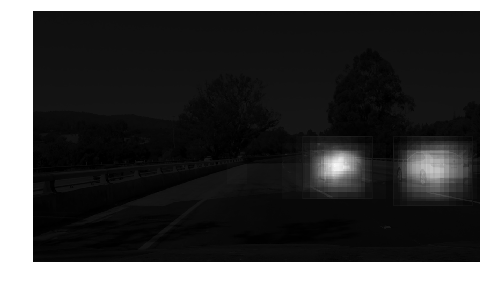

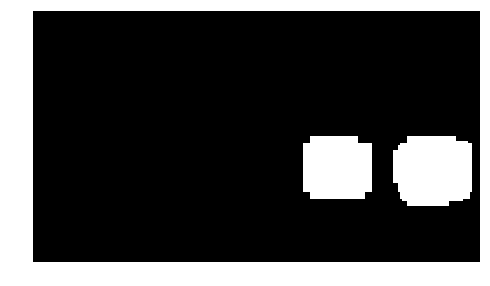

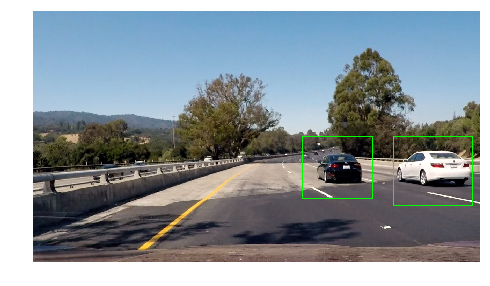

In [10]:
# test vehicle detection 
img = cv2.imread('./test_images/test4.jpg')
sliding_window_detection(img, plot_result=True)


In [11]:

def filter_heat_map(heat_map, buffer_size = 10):    
    global heat_map_buffer    
    
    if ('heat_map_buffer' not in globals()) or (heat_map_buffer is None):
        heat_map_buffer = []

    if len(heat_map_buffer) < buffer_size:
        heat_map_buffer.append(heat_map)
    else:
        del heat_map_buffer[0]
        heat_map_buffer.append(heat_map)
        
    filtered_map = np.zeros_like(heat_map)
    
    # calculate average heat map
    for hm in heat_map_buffer:
        filtered_map += 1.0*hm/len(heat_map_buffer)
        
    return filtered_map


def check_rect_intersect(rect1, rect2):
    # check if the two rectangles intersect
    if (rect1[2]<rect2[0] or rect2[2]<rect1[0] or rect1[3]<rect2[1] or rect2[3]<rect1[1]):
        return False
    else:
        return True
    
def low_pass_filter(new_val, old_val, filter_coeff):
    return (1.0-filter_coeff)*new_val + filter_coeff*old_val

def filter_rectangle(rect, rect_old, filter_coeff):
    for i in range(4):
        rect[i] = int(low_pass_filter(rect[i], rect_old[i], filter_coeff)) 
        
    return rect

def draw_vehicle_rects(img, heat_map, rect_list_old, heat_threshold, rect_filter_coeff):
    
    heat_map_thresh = np.zeros_like(heat_map)
    heat_map_thresh[heat_map >= heat_threshold] = 1
    
    # label the separated regions of the thresholded heat map
    labeled_array, num_features = label(heat_map_thresh)
    
    rect_list = []
    
    # create bounding rectangles of labeled regions
    for i in range(num_features):
        x_ind, y_ind = np.nonzero(labeled_array == i+1)
        
        rect = [np.min(y_ind), np.min(x_ind), np.max(y_ind), np.max(x_ind)]
        width = rect[2] - rect[0]
        height = rect[3] - rect[1]
        
        # check if the rectangle has a valid aspect ratio 
        if width*1.0/height > 0.85:
            rect_list.append(rect)  
    
    # calculate with how many of the current bounding boxes each of the old bounding boxes overlap
    # -> this is needed for correctly filtering the bounding boxes when one big box is split up into smaller parts 
    for rect_old in rect_list_old:
        rect_old.append(0)
        
        for rect in rect_list:
            if check_rect_intersect(rect, rect_old):
                rect_old[4] += 1 # number of intersections with new rectangles
    
    # filter bounding boxes 
    for rect in rect_list:
        for rect_old in rect_list_old:     
            if check_rect_intersect(rect, rect_old) and rect_old[4] <= 1:
                rect = filter_rectangle(rect, rect_old, rect_filter_coeff)   
                
        draw_rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]))        
    
        
    return img, rect_list


In [12]:
rect_list = []
def video_vehicle_detection(img, plot_result=False):    
    global rect_list    
    
    heat_map = calculate_heat_map(img) 
        
    heat_map_filtered = filter_heat_map(heat_map)    

    heat_threshold = calculate_heat_threshold(heat_map_filtered)

    img_with_rects, rect_list = draw_vehicle_rects(img, heat_map_filtered, rect_list, 
                                                   heat_threshold = heat_threshold, rect_filter_coeff = 0.7) # threshold 2.5, filter 0.7
        
    if plot_result:
        img_gray = convert_to_gray(img)
        res = cv2.addWeighted(img_gray.astype('float64'), 0.8, heat_map_filtered, 30.0, 0)
        plot_image(res)  
        
        plot_image(img_with_rects)

    return img_with_rects
        

In [13]:
# start_frame = 800 # black car, white is behind
# start_frame = 450 # in front of green sign
# start_frame = 580 # after bright asphalt area

start_frame = 0
num_frames = 100

# define codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 24.0, (img.shape[1],img.shape[0]))

# read input video
vidcap = cv2.VideoCapture('project_video.mp4')
img_count = 0
heat_map = None
heat_map_buffer = None
rect_list = []
success, img = vidcap.read()

# loop over video frames
while success:      
  
    img_count += 1  

    if img_count > start_frame:        
        
        video.write(img_with_rects)     
        print(img_count)
        
        
    if img_count >= start_frame + num_frames:
        break
        
    success, img = vidcap.read()
    
video.release() 
print('finished!')


finished!


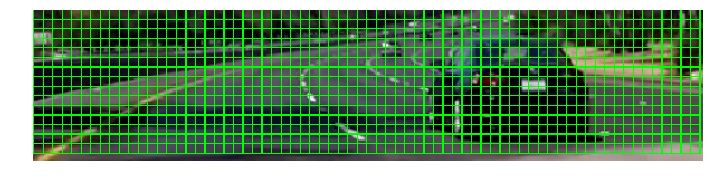

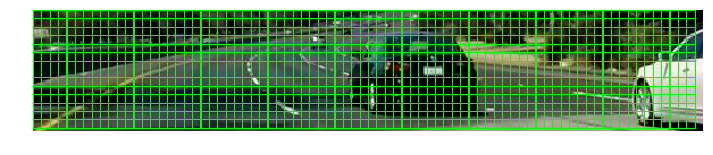

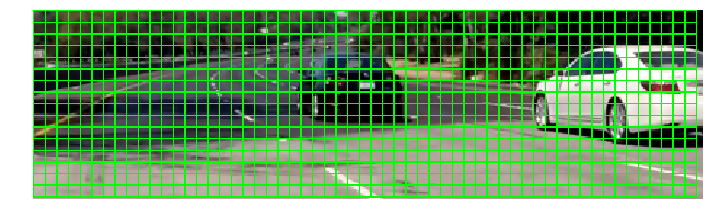

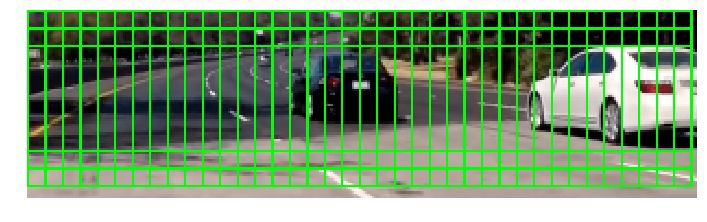

In [14]:
def plot_sub_images(img):
    for level in detection_levels:
        
        # resize the image according to the current detection level 
        img_resized = level.crop_image(img) 
    
        img_patches = level.get_patches(img_resized)[0]        
        plot_image(draw_patches(img_resized, img_patches), size=(12,5))

img = cv2.imread('./test_images/test5.jpg')
plot_sub_images(img)
